In [0]:
df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/ptw190000@utdallas.edu/Housing.csv")
df2 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/ptw190000@utdallas.edu/ratings.dat")

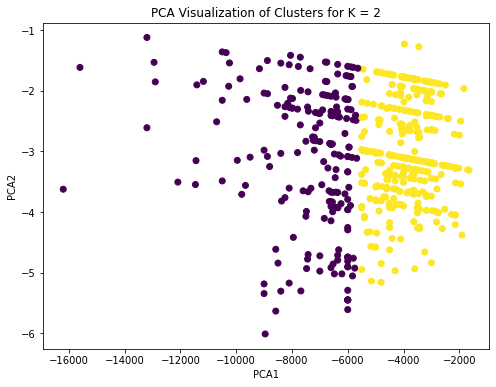

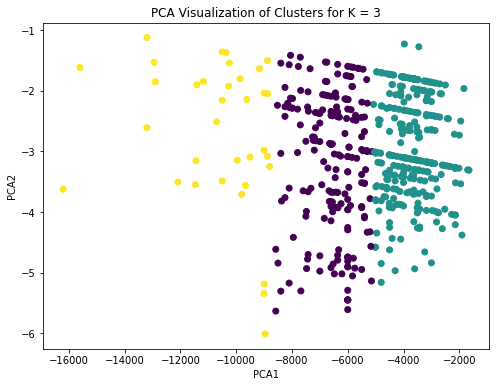

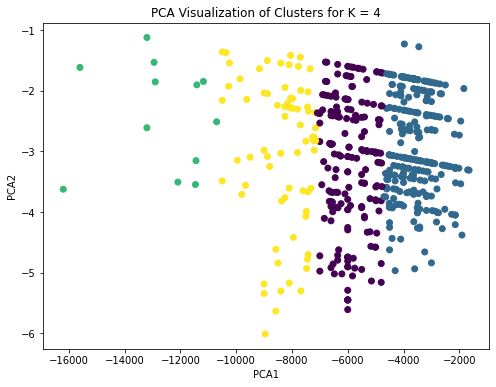

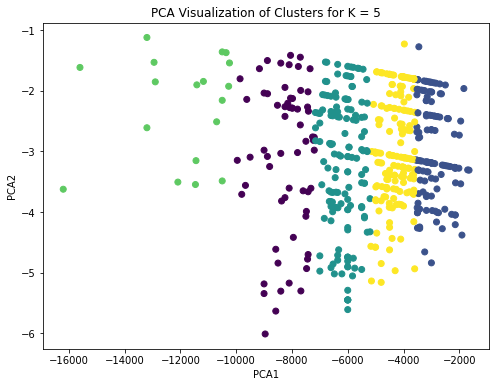

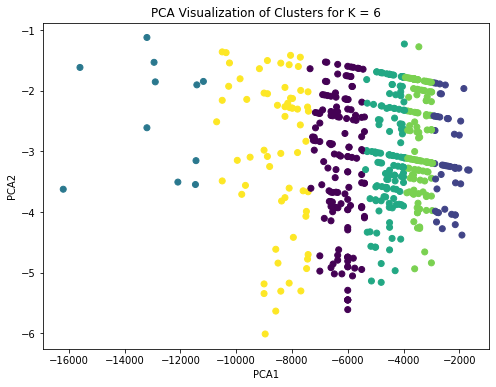

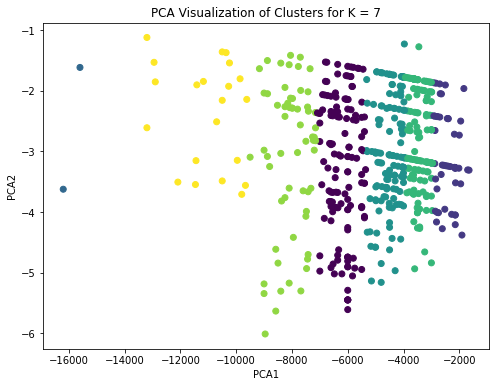

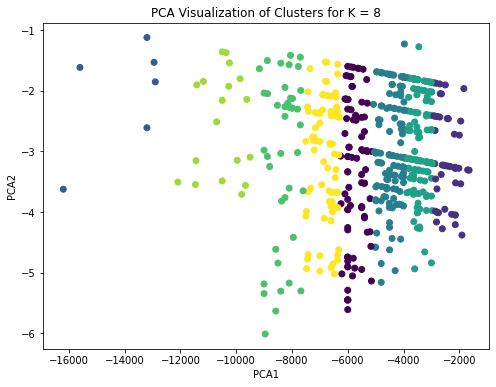

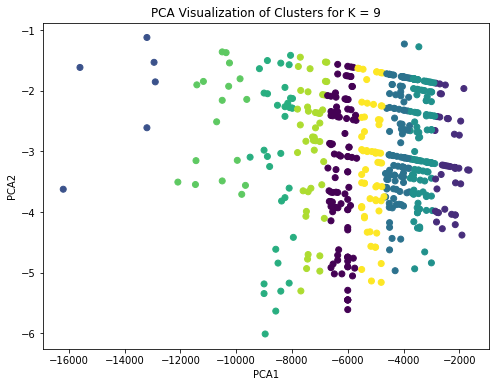

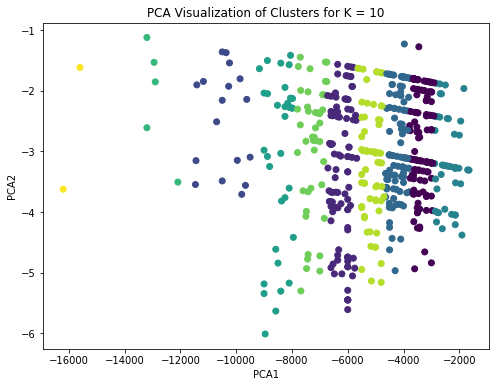

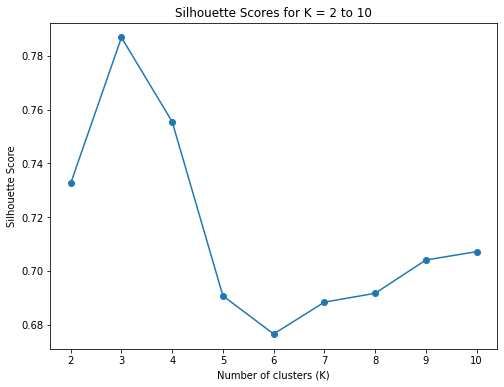

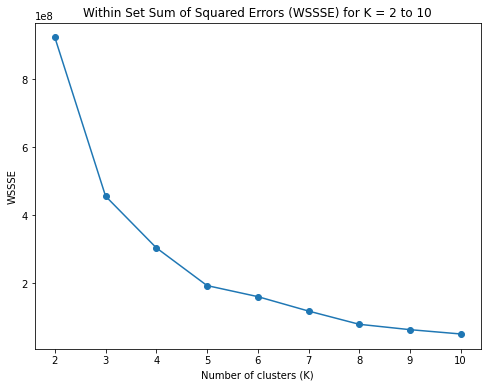

In [0]:
# Q4 Part A: K-Means Clustering

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize Spark Session
spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

# Load the dataset
housing_data = spark.read.csv("dbfs:/FileStore/shared_uploads/ptw190000@utdallas.edu/Housing.csv", header=True, inferSchema=True)

# Remove the categorical features
housing_data = housing_data.drop('mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus')

# Convert all features into a single vector column "features"
feature_columns = housing_data.columns
feature_columns.remove('price')  # Assuming 'price' is not a feature but the target
vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
housing_data = vec_assembler.transform(housing_data)

# Initialize variables for plotting
silhouette_scores = []
wssse_values = []
k_values = range(2, 11)

# Analyze clusters for K = 2 to 10
for k in k_values:
    # Train the KMeans model
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(housing_data)

    # Make predictions
    predictions = model.transform(housing_data)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)

    # Evaluate clustering by computing Within Set Sum of Squared Errors
    wssse = model.summary.trainingCost
    wssse_values.append(wssse)

    # To visualize the clusters using PCA, we'll reduce the data to 2 dimensions and plot
    pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
    pca_model = pca.fit(predictions)
    pca_result = pca_model.transform(predictions).select("pcaFeatures")
    pca_result = np.array(pca_result.rdd.map(lambda row: row.pcaFeatures.toArray()).collect())

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:,0], pca_result[:,1], c=model.summary.predictions.rdd.map(lambda row: row.prediction).collect())
    plt.title(f'PCA Visualization of Clusters for K = {k}')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.show()

# Plot Silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for K = 2 to 10')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# Plot WSSSE values
plt.figure(figsize=(8, 6))
plt.plot(k_values, wssse_values, marker='o')
plt.title('Within Set Sum of Squared Errors (WSSSE) for K = 2 to 10')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WSSSE')
plt.show()

In [0]:
# Q4 Part B
"""
Run K-means clustering method for K = 2 to 10 and visualize the clusters using PCA.
Compare and discuss the result. How does the optimal value of K compare with your
answer in part (a).

We see that on K = 3, we get the highest score achieved under the Silhouette score plot. 
This suggests that 3 is the optimal number of clusters. The high silhouette score indicates that it matches to its clusters well. 
When going above 3, we see a drop, suggesting that we get diminishing return on the separation. 

Part C

The WSSSE drops from 2 to 10 with the increase of clusters. This is expected because as the clusters become smaller, the data points 
go closer to its respective centroids, and thus reducing the SSE.
"""

Out[4]: '\nRun K-means clustering method for K = 2 to 10 and visualize the clusters using PCA.\nCompare and discuss the result. How does the optimal value of K compare with your\nanswer in part (a).\n\nWe see that on K = 3, we get the highest score achieved under the Silhouette score plot. \nThis suggests that 3 is the optimal number of clusters. The high silhouette score indicates that it matches to its clusters well. \nWhen going above 3, we see a drop, suggesting that we get diminishing return on the separation. \n\nPart C\n\nThe WSSSE drops from 2 to 10 with the increase of clusters. This is expected because as the clusters become smaller, the data points \ngo closer to its respective centroids, and thus reducing the SSE.\n'

In [0]:
# Q5 Recommendation System
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F

# Initialize Spark Session
spark = SparkSession.builder.appName("ALSExample").getOrCreate()

# Load the ratings data
ratings_data = spark.read.text("dbfs:/FileStore/shared_uploads/ptw190000@utdallas.edu/ratings.dat")

# Split the data into columns
split_col = F.split(ratings_data['value'], '::')
ratings_data = ratings_data.withColumn('userId', split_col.getItem(0).cast('int'))
ratings_data = ratings_data.withColumn('movieId', split_col.getItem(1).cast('int'))
ratings_data = ratings_data.withColumn('rating', split_col.getItem(2).cast('float'))
ratings_data = ratings_data.withColumn('timestamp', split_col.getItem(3).cast('int'))
ratings_data = ratings_data.drop('value')

# Split the data into training and test sets (70% training, 30% test)
(training, test) = ratings_data.randomSplit([0.7, 0.3])

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(training)

# Evaluate the model by computing the MSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
mse = evaluator.evaluate(predictions.na.drop())  # drop rows where prediction is NaN

# 0.834 ... is MSE, or the answer to Q5
mse

Out[7]: 0.8346718523517864

In [0]:
!pip install sparknlp

     |████████████████████████████████| 540 kB 6.0 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-53663add-9f44-432c-b9f9-76dc50b13e12/bin/python -m pip install --upgrade pip' command.


In [0]:
from pyspark.sql import SparkSession
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# Start Spark session with Spark NLP
spark = SparkSession.builder \
    .appName("Spark NLP") \
    .master("local[4]") \
    .config("spark.driver.memory","16G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.5") \
    .getOrCreate()

# Load the train and test datasets
train_df = spark.read.csv("dbfs:/FileStore/shared_uploads/ptw190000@utdallas.edu/Train.csv", header=True, multiLine=True, escape='\"')
test_df = spark.read.csv("dbfs:/FileStore/shared_uploads/ptw190000@utdallas.edu/Test-1.csv", header=True, multiLine=True, escape='\"')

# Explore data distribution
train_distribution = train_df.groupBy("label").count().show()
test_distribution = test_df.groupBy("label").count().show()

# Universal Sentence Encoder for text embeddings
document_assembler = DocumentAssembler()\
    .setInputCol("review")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained() \
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

# Classifier model
classifier = LogisticRegression(featuresCol="sentence_embeddings", labelCol="sentiment")

# Pipeline
pipeline = Pipeline(stages=[
    document_assembler, 
    use, 
    classifier
])

# Fit the model
model = pipeline.fit(train_df)

# Predict
predictions = model.transform(test_df)

# Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


# Attempted Q6 .. I couldn't get past the error, not sure what the problem is. 


+-----+-----+
|label|count|
+-----+-----+
|    0|20019|
|    1|19981|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0| 2495|
|    1| 2505|
+-----+-----+

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<command-3287270190522461>", line 26, in <module>
    document_assembler = DocumentAssembler()\
  File "/databricks/spark/python/pyspark/__init__.py", line 135, in wrapper
    return func(self, **kwargs)
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-53663add-9f44-432c-b9f9-76dc50b13e12/lib/python3.9/site-packages/sparknlp/base/document_assembler.py", line 96, in __init__
    super(DocumentAssembler, self).__init__(classname="com.johnsnowlabs.nlp.DocumentAssembler")
  File "/databricks/spark/python/pyspark/__init__.py", line 135, in wrapper
    return func(self, **kwargs)
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-53663add-9f44-432c-b9f9-76dc50b13e12/lib/python3.9/site-packages/sparknlp/internal/annotator_transformer.py", line 36, in __init__
    self._java_obj = self